# DBSCAN method of clustering for Online Retail Dataset

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular unsupervised clustering algorithm. It groups points that are closely packed together while marking points that are in low-density regions as outliers. 

There are 2 main parameters that the algorithm requires to perform clustering:
1.	Epsilon (ε): The maximum distance between two points for them to be considered as neighbors.
2.	MinPts: The minimum number of points required to form a dense region (a cluster).


Advantages
-	Can find arbitrarily shaped clusters: Unlike k-means, which assumes spherical clusters, DBSCAN can find clusters of any shape.
-	No need to specify the number of clusters: Unlike k-means, where you need to specify the number of clusters beforehand, DBSCAN only requires ε and MinPts.
-   Not sensitive to noise as it accounts for noise during labelling.

Disadvantages
-	Sensitive to parameter selection: The results can be highly sensitive to the choice of ε and MinPts.
-	Not suitable for varying densities: DBSCAN struggles with data that has clusters with varying densities, as it uses the same ε and MinPts for all clusters.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score

In [2]:
df = pd.read_csv("Customer_Data.csv")
df.head()

,ind,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [3]:
df.drop(columns=['ind', 'CustomerID', 'Is_UK'], inplace=True)
df.head()

,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,310,1,196,294.40,294.400000,16,0.000000,2,16


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Days_Since_Last_Purchase,4282.0,89.430406,99.095953,0.0,16.00000,48.00000,136.750000,373.000
Total_Transactions,4282.0,5.067959,9.150756,1.0,1.00000,3.00000,5.000000,242.000
Total_Products_Purchased,4282.0,1135.074031,4710.137648,-303.0,160.00000,375.00000,983.750000,196556.000
Total_Spend,4282.0,1925.758996,8339.406646,-1192.2,301.09500,656.00000,1615.315000,278778.020
Average_Transaction_Value,4282.0,322.515270,387.226533,-1192.2,153.64625,239.07000,369.134205,9904.875
Unique_Products_Purchased,4282.0,62.293321,85.759810,1.0,16.00000,36.00000,78.000000,1791.000
Average_Days_Between_Purchases,4282.0,3.438484,11.455366,0.0,0.00000,1.19238,3.123922,309.000
Day_Of_Week,4282.0,2.542737,1.847660,0.0,1.00000,2.00000,4.000000,6.000
Hour,4282.0,12.484587,2.308970,7.0,11.00000,12.00000,14.000000,20.000


c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\arnav\anaconda3\envs\practice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

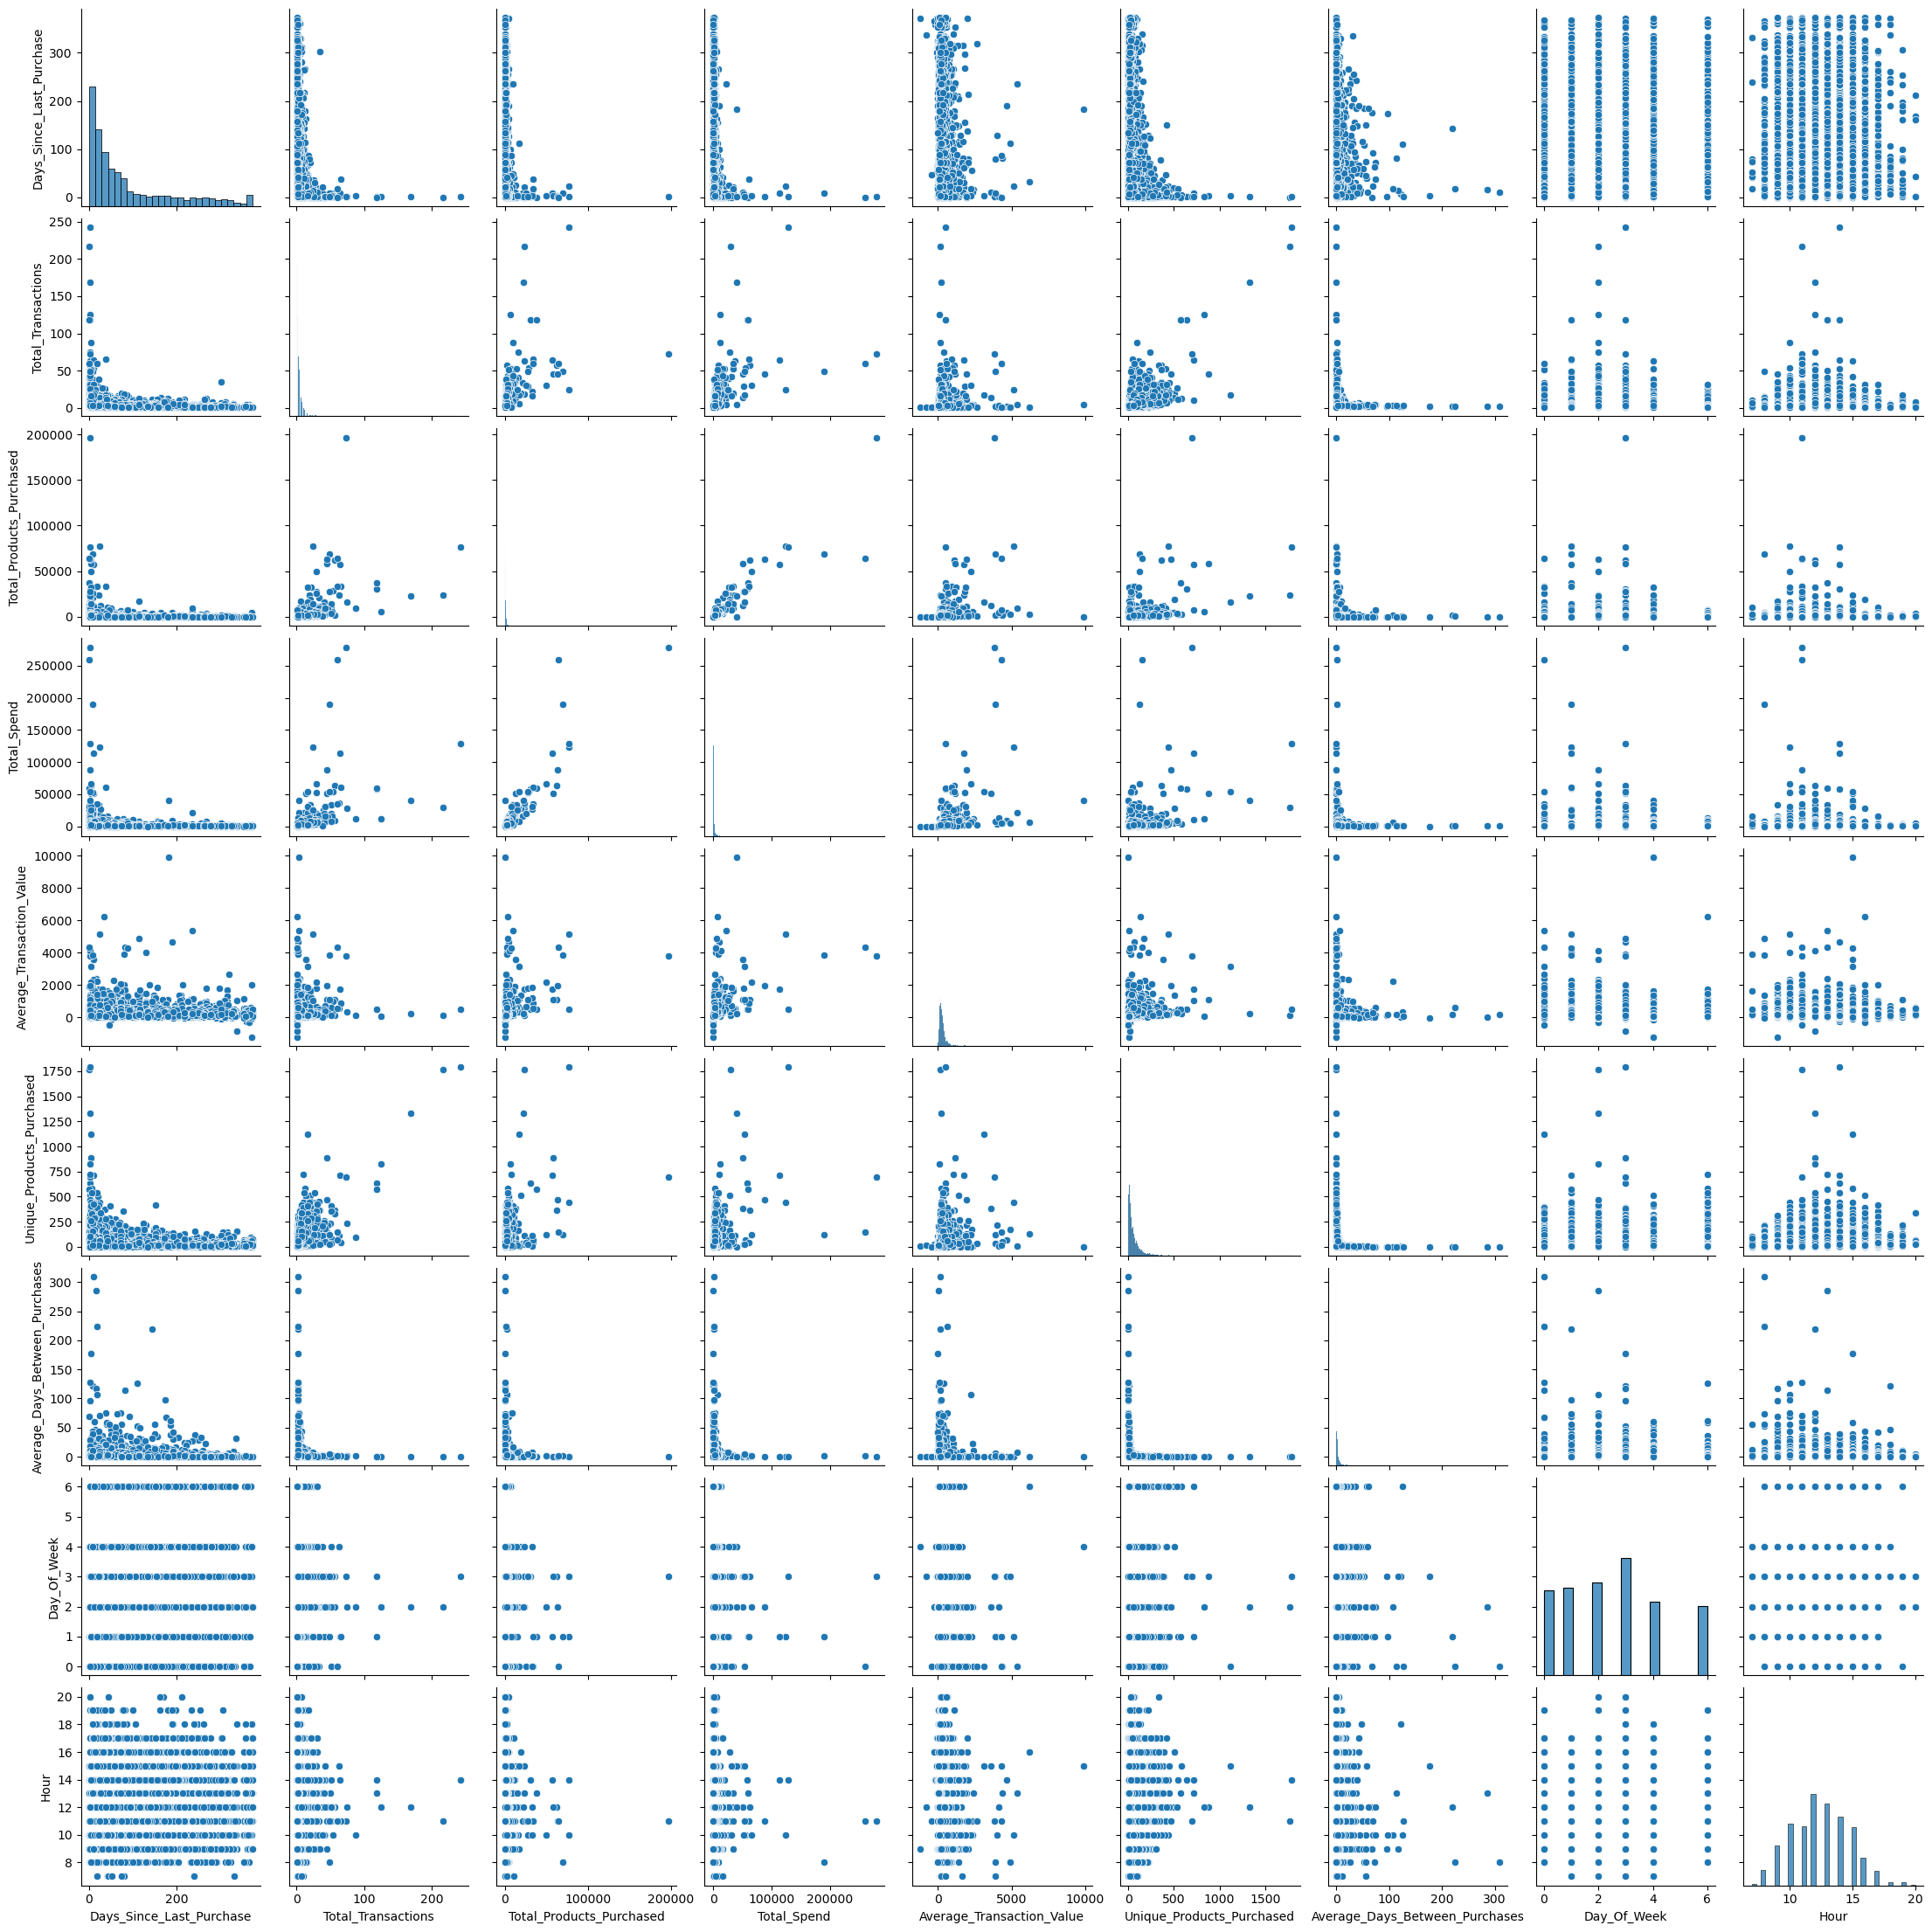

In [8]:
sns.pairplot(df)

In [5]:
# Find the optimal values of eps and min_samples using GridSearchCV
param_grid = {
    'eps': np.arange(0.1, 5, 0.1),
    'min_samples': range(3, 15)
}


# Custom scorer function
def silhouette_scorer(estimator, X):
    labels = estimator.fit(X).labels_
    # Check if the number of clusters is more than 1
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # Return a low score if clustering fails (i.e., all points in one cluster or all are noise)

# Perform grid search
grid_search = GridSearchCV(DBSCAN(), param_grid, scoring=silhouette_scorer)
grid_search.fit(df)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'eps': 0.1, 'min_samples': 3}
Best Score: -1.0


In [6]:
# Compute the labels using DBSCAN
clustering = DBSCAN(eps=0.1, min_samples=3).fit(df)
labels = clustering.labels_

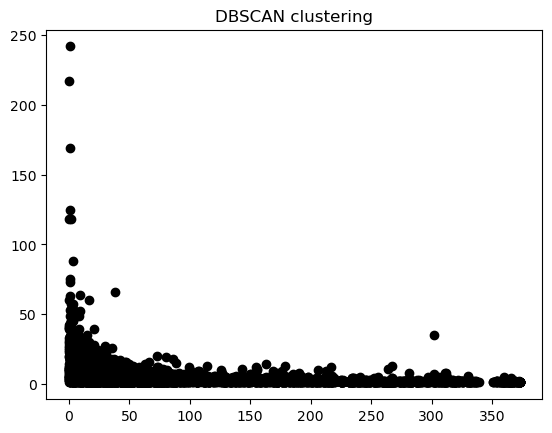

In [7]:
# Plot results
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black is used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df[class_member_mask].values
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustering')
plt.show()